In [133]:
import pandas as pd
import numpy as np
from pathlib import Path


# Step 1: Data Loading

Before analyzing delivery efficiency, it is essential to load all datasets and validate them. This step ensures that:
- The correct files are being used.
- Relevant columns, such as dates, are parsed correctly.
- Data is ready for quality assessment and cleaning.

The four datasets loaded are:
1. **deliveries** – Main transactional data about package deliveries.
2. **drivers** – Information about delivery drivers.
3. **warehouses** – Details about company warehouses.
4. **zones** – Information about delivery zones.

We also inspect the first few rows and shapes of the datasets to confirm the data matches the data dictionary.


In [134]:
DATA_DIR = Path("../data")


#Loading CSV
deliveries = pd.read_csv(DATA_DIR / "data_deliveries.csv", parse_dates=["date"])
drivers = pd.read_csv(DATA_DIR / "data_drivers.csv", parse_dates=["last_training_date"])
warehouses = pd.read_csv(DATA_DIR / "data_warehouses.csv")
zones = pd.read_csv(DATA_DIR / "data_zones.csv")

# Step 2: Data Quality Assessment & Cleaning

Before performing analysis, it is crucial to assess the quality of all datasets. This involves:

- **Checking for missing values**: Missing data can cause errors or bias results. 
- **Checking for duplicates**: Duplicate rows can skew statistics and insights.
- **Verifying data types**: Ensures dates, numeric, and categorical columns are correctly recognized.
- **Initial cleaning**: Impute or fill missing values, drop duplicates, and convert dates.

This step ensures that the data is reliable, clean, and ready for feature engineering and analysis.


In [135]:
# Function to summarize dataset quality

def data_quality_summary(df,name):
    print(f"-----{name}-----")
    print("shape:",df.shape)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nduplicates:", df.duplicated().sum())
    print("\ndatatypes:",df.dtypes)
    print("\n")


# Check all datasets
data_quality_summary(deliveries, "Deliveries")
data_quality_summary(drivers, "Drivers")
data_quality_summary(warehouses, "Warehouses")
data_quality_summary(zones, "Zones")

-----Deliveries-----
shape: (45000, 30)

Missing Values:
 package_id                    0
date                          0
time_of_day                   0
driver_id                     0
warehouse_id                  0
delivery_zone_id              0
package_type                  0
package_weight             2306
package_width                 0
package_height                0
package_depth                 0
package_value              2236
promised_delivery_time        0
actual_delivery_time          0
delivery_status               0
customer_rating            2237
weather_condition             0
traffic_condition             0
fuel_consumption           2496
vehicle_type                  0
is_return_trip                0
customer_id                   0
payment_method                0
promotional_code_used         0
is_new_customer               0
package_insurance             0
has_mobile_notification       0
delivery_cost              2306
profitability              6358
optimization_f

## Data Quality Analysis

- The **Deliveries** dataset contains **missing values**.  
- The **Drivers**, **Warehouses**, and **Zones** datasets do **not** have missing values.  




In [136]:
deliveries=deliveries.dropna(subset=['package_weight'])
deliveries.isnull().sum()

package_id                    0
date                          0
time_of_day                   0
driver_id                     0
warehouse_id                  0
delivery_zone_id              0
package_type                  0
package_weight                0
package_width                 0
package_height                0
package_depth                 0
package_value              2131
promised_delivery_time        0
actual_delivery_time          0
delivery_status               0
customer_rating            2110
weather_condition             0
traffic_condition             0
fuel_consumption           2370
vehicle_type                  0
is_return_trip                0
customer_id                   0
payment_method                0
promotional_code_used         0
is_new_customer               0
package_insurance             0
has_mobile_notification       0
delivery_cost                 0
profitability              4052
optimization_factor           0
dtype: int64

In [137]:
deliveries=deliveries.dropna(subset=['fuel_consumption','package_value','customer_rating','profitability'])
deliveries.isnull().sum()

package_id                 0
date                       0
time_of_day                0
driver_id                  0
warehouse_id               0
delivery_zone_id           0
package_type               0
package_weight             0
package_width              0
package_height             0
package_depth              0
package_value              0
promised_delivery_time     0
actual_delivery_time       0
delivery_status            0
customer_rating            0
weather_condition          0
traffic_condition          0
fuel_consumption           0
vehicle_type               0
is_return_trip             0
customer_id                0
payment_method             0
promotional_code_used      0
is_new_customer            0
package_insurance          0
has_mobile_notification    0
delivery_cost              0
profitability              0
optimization_factor        0
dtype: int64

In [138]:
# Keep raw deliveries
deliveries_raw = deliveries.copy()

# Create enriched dataset for analysis
deliveries_enriched = (
    deliveries_raw
    .merge(drivers[["driver_id", "years_experience"]], on="driver_id", how="left", suffixes=("","_drivers"))
    .merge(zones, left_on="delivery_zone_id", right_on="zone_id", how="left", suffixes=("","_zones"))
    
)


In [139]:
deliveries_raw.shape

(36742, 30)

In [140]:
deliveries_enriched.shape

(36742, 42)

In [141]:
#Delivery Delay
deliveries_enriched['delivery_delay'] = deliveries_enriched['actual_delivery_time'] - deliveries_enriched['promised_delivery_time']

#Is delayed (0 = on time, 1 = delayed)
deliveries_enriched['is_delayed'] = deliveries_enriched['delivery_delay'].apply(lambda x:1 if x > 0 else 0)

#Package Volume (cm^3)
# deliveries_enriched['package_volume'] = deliveries_enriched['package_depth'] * deliveries_enriched['package_height'] * deliveries_enriched['package_width']

#Fuel efficiency
#We need to merge zone distance to deiveries

#deliveries_enriched = deliveries_enriched.merge(zones[['zone_id','distance_from_hub']],left_on='delivery_zone_id', right_on='zone_id', how='left')

deliveries_enriched['fuel_efficiency'] = deliveries_enriched['fuel_consumption'] / deliveries_enriched['distance_from_hub']
#Dropping the duplicate zone_id column from merge
#deliveries_enriched = deliveries_enriched.drop(columns=['zone_id'])


#Driver Experience Bucket
# Merge driver experience

#deliveries_enriched = deliveries_enriched.merge(drivers[['driver_id','years_experience']], on='driver_id', how='left')


def experience_bucket(years):
    if years<3:
        return 'Novice'
    
    elif years<7:
        return 'Intermediate'
    
    else:
        return 'Expert'
    
deliveries_enriched['driver_experience_level'] = deliveries_enriched['years_experience'].apply(experience_bucket)

## Creating a Positive-Only Delivery Delay Metric

During the analysis, I noticed that the **Delivery Delay** variable also contained **negative values**,  
which represent **early deliveries**.  

Since the focus is on delays, I created a new metric called **Delivery Time**,  
which only retains the **positive values** (actual delayed time).  

This ensures that subsequent analyses (distribution, correlations, and impact studies)  
are based solely on **delays**, not early deliveries.


In [142]:
deliveries_enriched['delay_time']= deliveries_enriched['delivery_delay'].apply(lambda x:x if x>0 else 0)

## Distribution of Delivery Delay Time

To understand how delivery delays are distributed, I plotted a **histogram** of the `delay_time` variable from the deliveries dataset.  
This helps to identify whether delays are normally distributed, skewed, or contain outliers.  


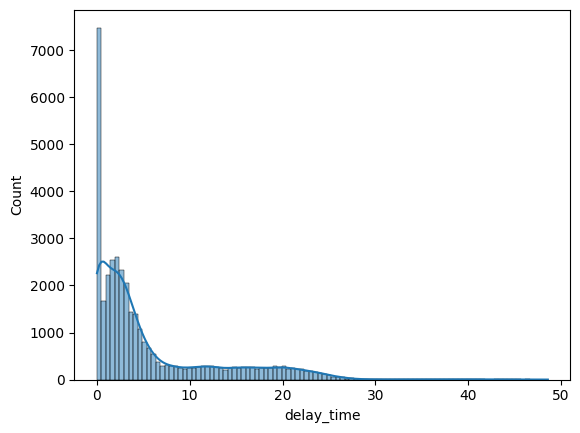

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(deliveries_enriched['delay_time'],bins=100,kde=True)
plt.show()

## Correlation Analysis of Delivery Performance Metrics

To evaluate the factors that may influence **delivery performance**, I selected the following metrics:

- **Delay Time**  
- **Fuel Consumption**  
- **Fuel Efficiency**  
- **Delivery Delay**  
- **Weather Condition**  
- **Traffic Condition**  
- **Driver Experience Level**

Since *Weather Condition*, *Traffic Condition*, and *Driver Experience Level* were categorical, I converted them into **numeric representations** to include them in the correlation analysis.

After preparing the data, I plotted a **correlation heatmap** to visualize the relationships between these variables and identify the strongest drivers of delivery performance.


In [144]:
weather_enc= {'Windy':1,'Rainy':2,'Clear':3,'Stormy':4,'Cloudy':5,'Snowy':6,'Foggy':7}
traffic_enc={'Moderate':1,'Severe':2,'Heavy':3,'Light':4}
experience_enc={'Expert':3,'Intermediate':2,'Novice':1}
deliveries_enriched['weather_encoding'] = deliveries_enriched['weather_condition'].apply(lambda x:weather_enc[x])
deliveries_enriched['traffic_encoding'] = deliveries_enriched['traffic_condition'].apply(lambda x:traffic_enc[x])
deliveries_enriched['driver_experience_encoding']= deliveries_enriched['driver_experience_level'].apply(lambda x:experience_enc[x])

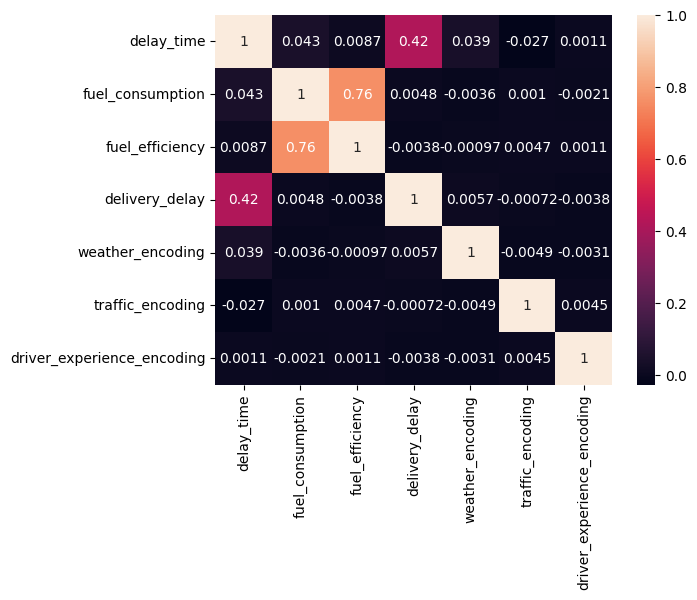

In [145]:
corr= deliveries_enriched[['delay_time','fuel_consumption','fuel_efficiency','delivery_delay','weather_encoding','traffic_encoding','driver_experience_encoding']].corr()
sns.heatmap(corr, annot=True)
plt.show()

## Scatterplot Analysis: Weather & Traffic Impact on Delivery

The correlation heatmap did not show any strong linear relationships among the selected variables.  
Since **Weather Condition** and **Traffic Condition** are still expected to significantly affect delivery performance,  
I plotted **scatterplots** to further explore their impact on **Delivery Delay Time**.  

This allows for a more detailed inspection of potential **non-linear patterns** or clusters that the correlation matrix may have missed.


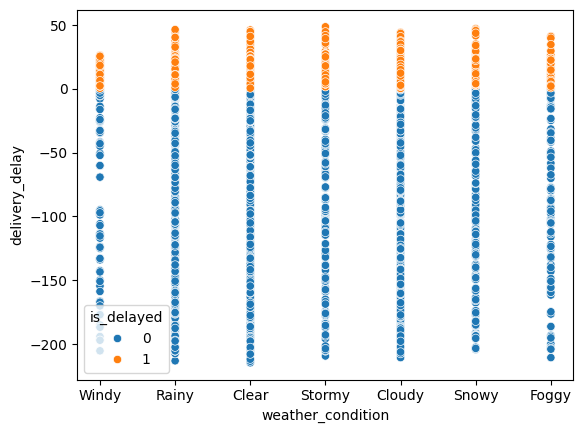

In [146]:

sns.scatterplot(data=deliveries_enriched, y='delivery_delay', x='weather_condition', hue='is_delayed')
plt.show()

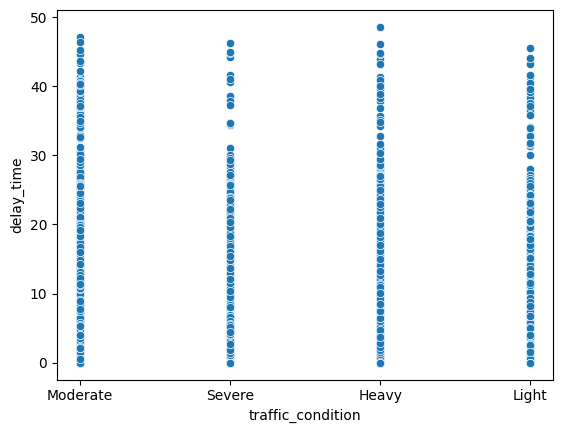

In [147]:
sns.scatterplot(data=deliveries_enriched,x='traffic_condition', y='delay_time')
plt.show()

## Findings: Traffic & Weather vs Delivery Performance

After analyzing **Delay Time** against **Traffic Conditions** and **Weather Conditions** using scatterplots,  
I did **not observe any significant patterns or strong relationships**.  

This result was **surprising**, since based on prior expectations and real-world experience,  
both weather and traffic conditions were assumed to have a **major impact** on delivery performance.  

The absence of a clear pattern suggests that:
- Either these factors are **not captured with enough granularity** in the dataset, or  
- Other hidden variables (e.g., vehicle type, zones, parking difficulty or seasonal speciality )  
  may play a larger role in influencing delivery delays.


## Boxplot Analysis: Weather & Traffic Conditions

To further confirm the earlier findings, I plotted **boxplots** of  
**Delay Time** and **Delivery Status** against **Weather Conditions** and **Traffic Conditions**.  

The goal was to identify whether there might be **any subtle patterns** or differences  
that were not visible in the scatterplots.  

However, even with this approach, I could not find any strong or consistent patterns  
linking weather or traffic conditions with delivery performance.


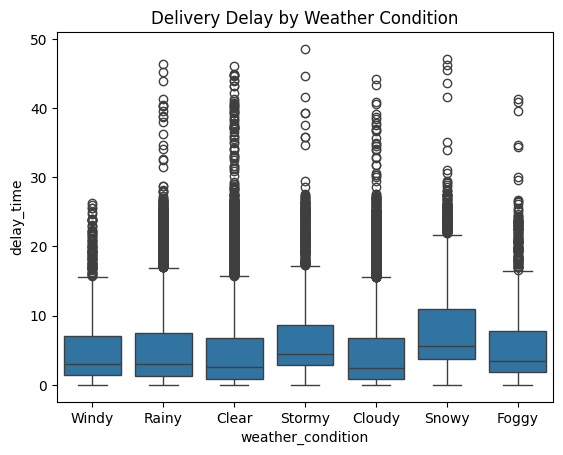

In [148]:
sns.boxplot(x='weather_condition', y='delay_time', data=deliveries_enriched)
plt.title("Delivery Delay by Weather Condition")
plt.show()

## Key Insight: Severe Conditions and Delays

From the **boxplot analysis**, I observed that a portion of deliveries tend to experience  
**significant delays** under the following conditions:

- **Severe and Heavy Traffic**  
- **Stormy and Snowy Weather**

These findings suggest that adverse conditions do contribute to increased delivery delays.  
However, since delays also occur in normal conditions, we cannot conclude that  
**traffic and weather alone** are the primary drivers of delivery performance.  

Other operational or external factors may still be influencing the outcomes.


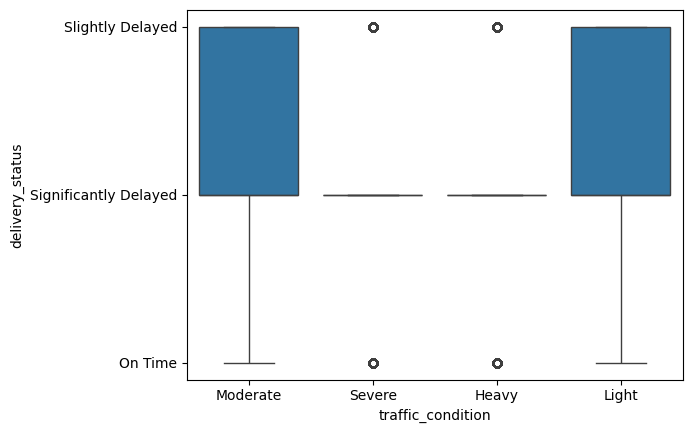

In [149]:
sns.boxplot(data=deliveries_enriched, x='traffic_condition', y='delivery_status')
plt.show()

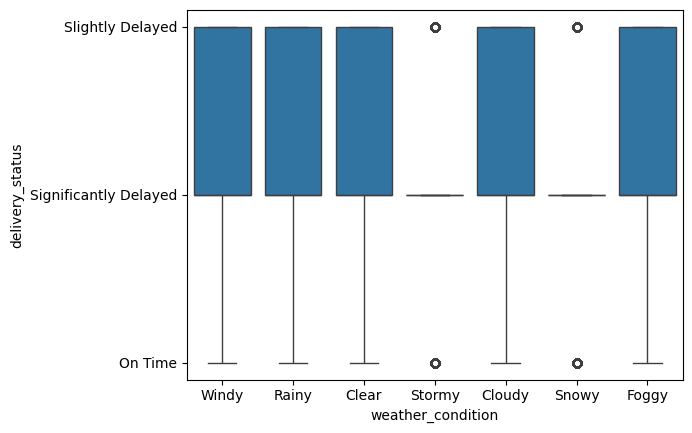

In [150]:
sns.boxplot(data=deliveries_enriched, x='weather_condition', y='delivery_status')
plt.show()

## Delivery Cost, Profitability, and Vehicle Type Analysis

After exploring delay-related factors, I extended the analysis to include  
**delivery cost** and **profitability**, with a focus on how these metrics vary  
across different **vehicle types**.  

To capture potential relationships, I examined:  

- **Delivery Cost & Profitability in relation to Delay Time and vehicle type**  

For better clarity, I plotted **separate scatterplots for each vehicle type**.  
This approach makes it easier to identify whether certain vehicle categories are  
associated with **higher costs, reduced profitability, or increased delays**.  

By combining cost, profitability, and delay time, the goal was to determine if  
vehicle selection plays a significant role in shaping **operational efficiency**  
and overall **delivery performance**.



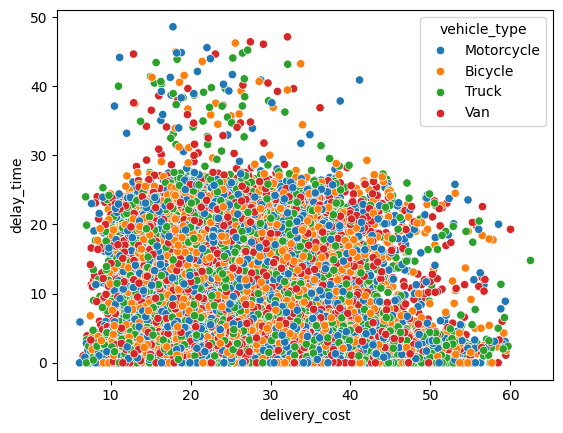

In [151]:
sns.scatterplot(data=deliveries_enriched, x='delivery_cost', y='delay_time', hue='vehicle_type')
plt.show()

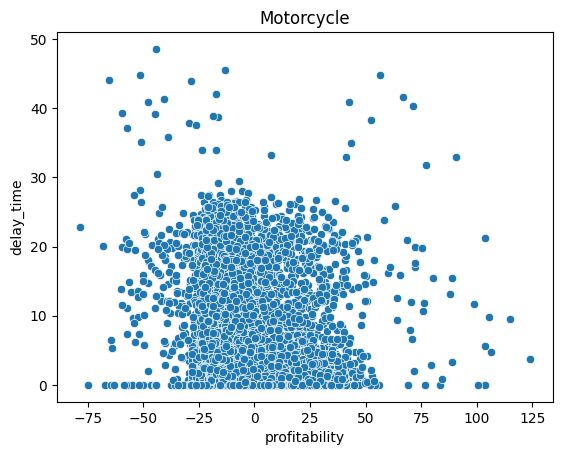

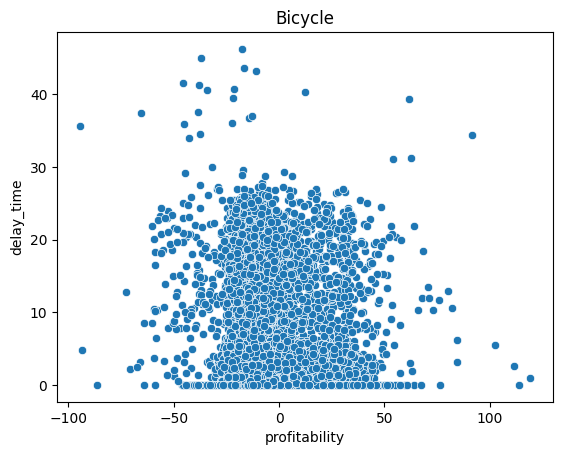

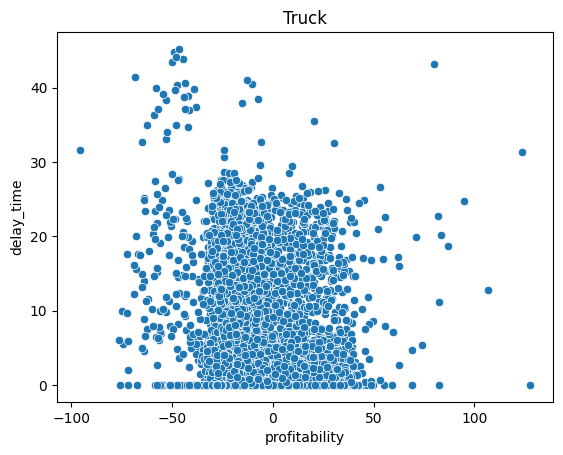

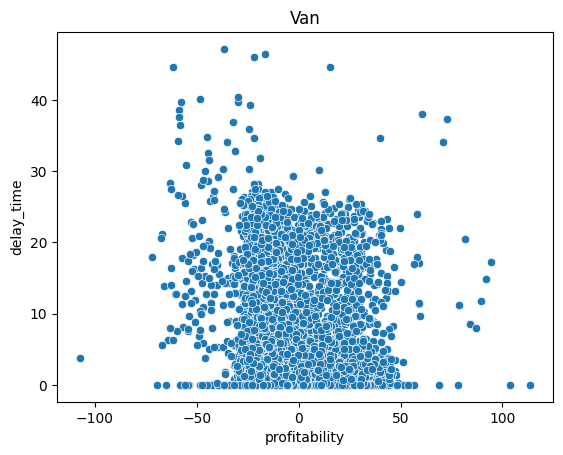

In [152]:
types=['Motorcycle','Bicycle','Truck','Van']
for vehicle in types:
    filtered=deliveries_enriched[deliveries_enriched['vehicle_type']==vehicle]
    sns.scatterplot(filtered, x='profitability', y='delay_time')
    plt.title(vehicle)
    plt.show()

In [153]:
# filtered=deliveries[deliveries['vehicle_type']==vehicle]
# sns.scatterplot(filtered, x='profitability', y='delay_time')
# plt.show()

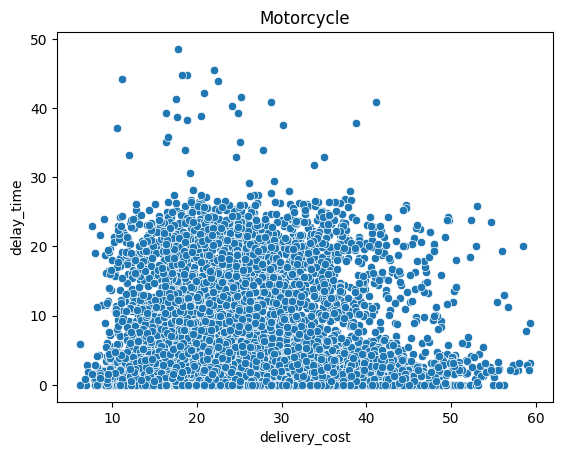

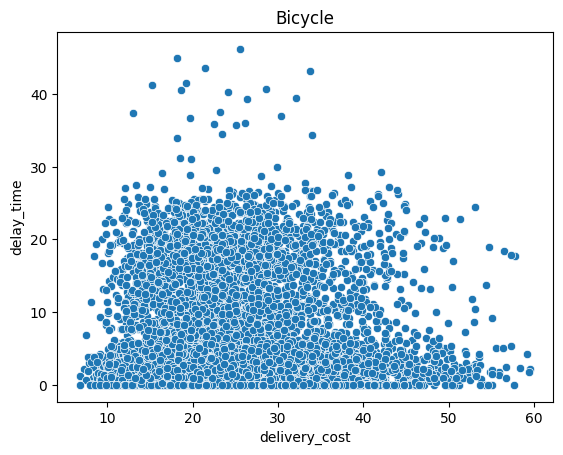

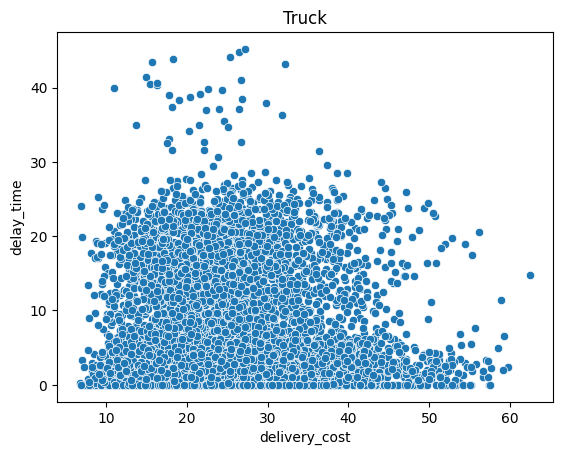

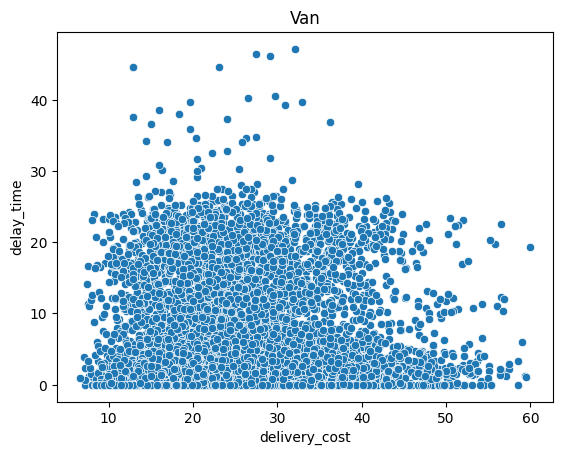

In [154]:
types=['Motorcycle','Bicycle','Truck','Van']
for vehicle in types:
    filtered=deliveries_enriched[deliveries_enriched['vehicle_type']==vehicle]
    sns.scatterplot(filtered, x='delivery_cost', y='delay_time')
    plt.title(vehicle)
    plt.show()

## Findings: Vehicle Type, Cost, and Profitability

From the scatterplot analysis of **Delivery Cost**, **Profitability**, and **Delay Time**  
across different **Vehicle Types**, I did **not observe any significant differences or clear patterns**.  

This suggests that vehicle type may not be a strong standalone driver of  
delivery performance, cost efficiency, or profitability.  

Given the lack of meaningful variation, I decided to move on and explore  
the next set of metrics in search of stronger influencing factors.


In [155]:
# Bin 'profitability' and label bins by their mean
# import math
# bins = pd.cut(deliveries['profitability'], bins=15)
# binned = deliveries.groupby(bins)['delay_time'].mean().reset_index()
# # Calculate mean of each bin for labeling
# bin_means = [math.floor(interval.mid) for interval in binned['profitability']]
# # Plot bar chart with mean as label
# sns.barplot(x=bin_means, y=binned['delay_time'])
# plt.xlabel('Profitability Bin Mean')
# plt.ylabel('Average Delay Time')
# plt.title('Average Delay Time by Profitability Bin (Mean Label)')
# plt.show()

In [156]:
# Bin 'delivery_cost' and use bins as x for boxplot
# import math
# bins = pd.cut(deliveries['delivery_cost'], bins=15)
# deliveries['profit_bin'] = bins
# # Use bin mean as label for x-axis
# bin_means = [math.floor(interval.mid) for interval in deliveries['profit_bin'].cat.categories]
# # Plot boxplot for each bin
# sns.boxplot(x=deliveries['profit_bin'].cat.codes, y=deliveries['delay_time'])
# plt.xlabel('delivery_cost Bin (Mean Label)')
# plt.ylabel('Delay Time')
# plt.title('Delay Time Distribution by delivery_cost Bin')
# plt.xticks(ticks=range(len(bin_means)), labels=bin_means, rotation=45)
# plt.show()
# # Optionally, remove the temporary column
# deliveries.drop('profit_bin', axis=1, inplace=True)

In [157]:
# sns.scatterplot(data=deliveries, x='profitability', y='delay_time', hue='vehicle_type')
# plt.show()

In [158]:
# sns.scatterplot(data=deliveries, x='optimization_factor', y='delay_time', hue='vehicle_type')
# plt.show()

In [159]:
# # Merge all datasets into a single master dataset
# # Load all CSVs (if not already loaded)
# # deliveries, drivers, warehouses, zones are assumed to be loaded as per earlier cells

# # Merge deliveries with drivers on 'driver_id'
# master = deliveries.merge(drivers, on='driver_id', how='left', suffixes=('', '_driver'))

# # Merge with warehouses on 'warehouse_id'
# master = master.merge(warehouses, on='warehouse_id', how='left', suffixes=('', '_warehouse'))

# # Merge with zones on 'delivery_zone_id' and 'zone_id'
# master = master.merge(zones, left_on='delivery_zone_id', right_on='zone_id', how='left', suffixes=('', '_zone'))

# # Preview the master dataset
# master.head()

In [160]:
# sns.boxplot(master, x='driver_rating', y='delay_time')
# plt.show()

In [161]:
# master['time_of_day']=pd.to_datetime(master['time_of_day'])
# master['time']=master['time_of_day'].dt.hour
# sns.boxplot(master, x='time', y='delay_time')
# plt.show()

In [162]:
# sns.boxplot(master, x='shift_preference', y='delay_time')
# plt.show()

## Date & Seasonal Analysis of Delivery Performance

After finding no strong impact from vehicle type, cost, or profitability,  
I shifted the focus to **temporal factors**. Specifically, I analyzed **Delay Time**  
with respect to **dates** to investigate whether there are any:  

- **Seasonal patterns** (e.g., winter vs summer effects)  
- **Monthly or weekly trends** (e.g., weekday vs weekend delays)  
- **Holiday or event-related spikes** in delivery delays  

The goal was to identify if delivery performance shows **seasonal specialities**  
or time-based fluctuations that could explain part of the variation in delay times.  


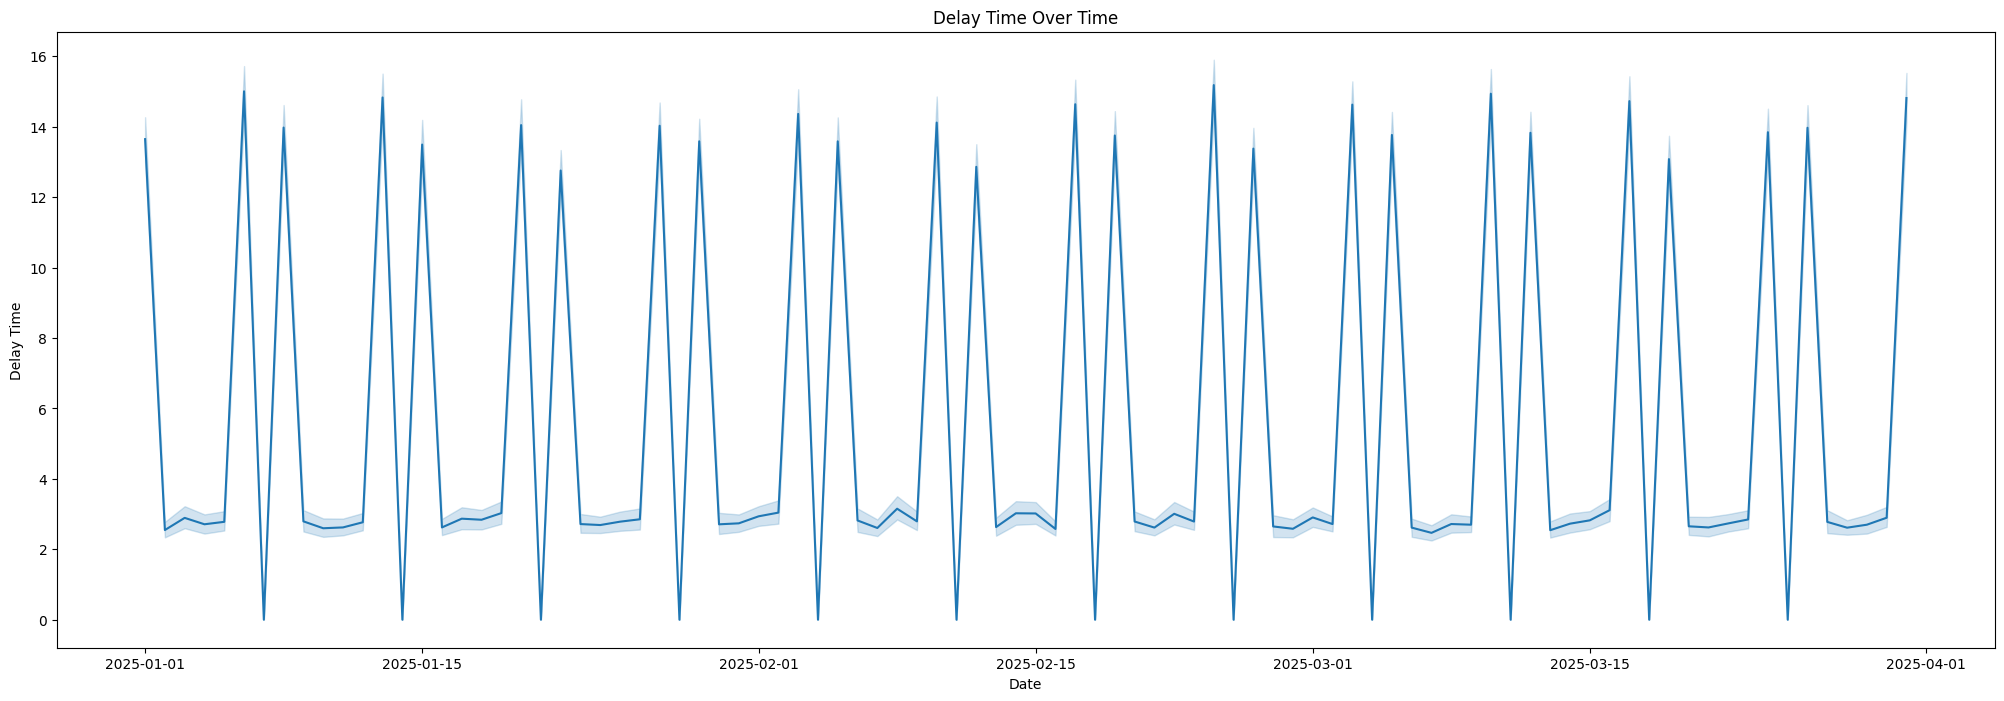

In [163]:
plt.figure(figsize=(25,8))
sns.lineplot(deliveries_enriched, x='date', y='delay_time')
plt.xlabel('Date')
plt.ylabel('Delay Time')
plt.title('Delay Time Over Time')
plt.show()

## Time-Series Patterns in Delivery Delays

When plotting a **line plot of Delay Time over Date**, I noticed a **repeating pattern**  
that appeared consistently over time.  

To better understand this trend, I performed a deeper analysis to check whether  
specific **weekdays** or **months** play a critical role in delivery performance.  

The objective was to identify:  
- If certain **days of the week** (e.g., Mondays or weekends) are prone to higher delays  
- If particular **months or seasons** consistently show spikes in delay time  
- Whether these time-based effects align with operational or external factors  


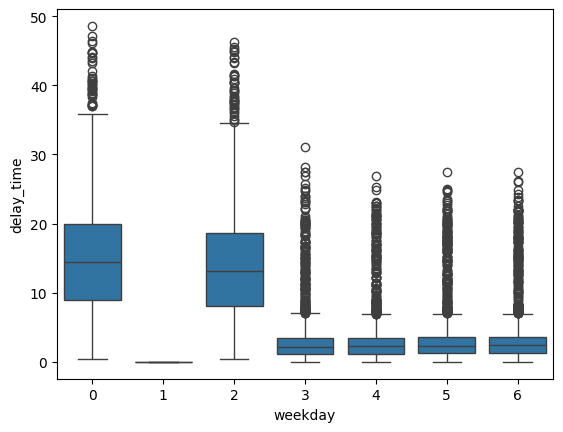

In [164]:
deliveries_enriched["weekday"] = deliveries_enriched["date"].dt.weekday
sns.boxplot(deliveries_enriched, x='weekday', y='delay_time')
plt.show()

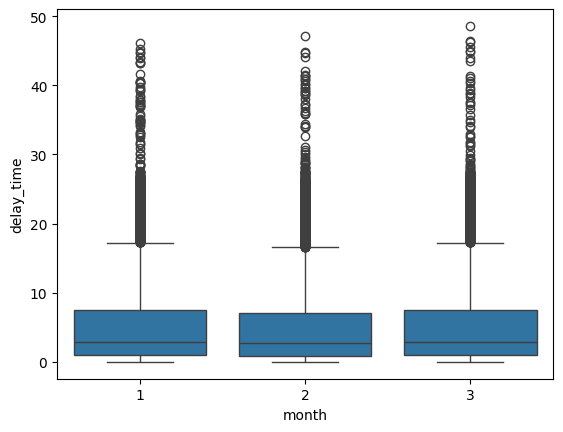

In [165]:
deliveries_enriched["month"] = deliveries_enriched["date"].dt.month
sns.boxplot(deliveries_enriched, x='month', y='delay_time')
plt.show()

## Weekday and Monthly Impact on Delivery Delays

From the temporal analysis, I found that **months do not play a significant role**  
in influencing delivery delays. However, a clear **weekday pattern** emerged:

- **Mondays and Wednesdays** show **significantly higher delays** compared to other days.  
- **Tuesdays** exhibit a **notable dip**, with the lowest delay times of the week.  
- Other weekdays remain relatively stable, without strong variations.  

This suggests that **weekday-specific operational factors** (such as workload distribution,  
scheduling practices, or demand surges) may be influencing delivery performance  
more than seasonal or monthly trends.


In [166]:
# sns.boxplot(master, x='payment_method', y='delay_time')
# plt.show()

In [167]:
# sns.boxplot(master, x='promotional_code_used', y='delay_time')
# plt.show()

In [168]:
# sns.boxplot(master, x='is_new_customer', y='delay_time')
# plt.show()

In [169]:
# sns.boxplot(master, x='has_mobile_notification', y='delay_time')
# plt.show()

In [170]:
# sns.boxplot(master, x='max_packages_per_day', y='delay_time')
# plt.show()

In [171]:
# sns.boxplot(master, x='vehicle_type', y='delay_time')
# plt.show()

In [172]:
# sns.boxplot(master, x='has_refrigeration_unit', y='delay_time')
# plt.show()

In [173]:
# sns.boxplot(master, x='salary_tier', y='delay_time')
# plt.show()

In [174]:
# sns.boxplot(master, x='bonus_eligible', y='delay_time')
# plt.show()

In [175]:
# sns.boxplot(master, x='capacity', y='delay_time')
# plt.show()

In [176]:
# sns.boxplot(master, x='has_automated_sorting', y='delay_time')
# plt.show()

## Boxplot Analysis of Geographical & Demographic Factors

To investigate whether **geographical and demographic variables** influence  
delivery performance, I plotted **boxplots** of **Delay Time** against:  

- **Distance from Hub**  
- **Population**  
- **Zones**  
- **Primary Warehouse**  
- **Zone growth rate**

The goal of this analysis was to check if deliveries associated with certain  
zones, population densities, or warehouse assignments show **systematic differences**  
in delay times, which could point to **location-driven performance challenges**.


In [177]:
deliveries_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36742 entries, 0 to 36741
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   package_id                  36742 non-null  object        
 1   date                        36742 non-null  datetime64[ns]
 2   time_of_day                 36742 non-null  object        
 3   driver_id                   36742 non-null  object        
 4   warehouse_id                36742 non-null  object        
 5   delivery_zone_id            36742 non-null  object        
 6   package_type                36742 non-null  object        
 7   package_weight              36742 non-null  float64       
 8   package_width               36742 non-null  float64       
 9   package_height              36742 non-null  float64       
 10  package_depth               36742 non-null  float64       
 11  package_value               36742 non-null  float64   

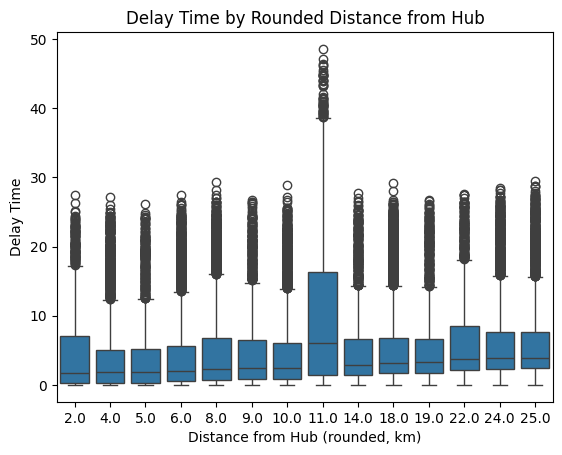

In [178]:
# Round distance_from_hub for x-axis
deliveries_enriched['distance_from_hub_rounded'] = deliveries_enriched['distance_from_hub'].round()
sns.boxplot(deliveries_enriched, x='distance_from_hub_rounded', y='delay_time')
plt.xlabel('Distance from Hub (rounded, km)')
plt.ylabel('Delay Time')
plt.title('Delay Time by Rounded Distance from Hub')
plt.show()

## Key Finding: Distance from Hub vs Delivery Delays

From the boxplot analysis, I observed that **distance from the hub** does  
influence delivery delays — but not in the expected way.  

- The **longest distances** from the hub did **not** show the highest delays.  
- Instead, deliveries at an **intermediate (middle-range) distance** from the hub  
  experienced the **most significant delays**.  

This suggests that factors other than simple travel distance — such as **routing  
complexity, traffic density at mid-range zones, or allocation inefficiencies** —  
may be contributing to these delays.


In [179]:
# sns.boxplot(master, x='last_training_date', y='delay_time')
# plt.xticks(rotation=45)

# plt.show()

## Patterns Across Population, Zone, Income, and Warehouse Factors

Similar patterns emerged when analyzing **Population**, **Zone ID**,  
**Average Income**,**Zone growth rate** and **Primary warehouse**

In each case, certain categories or ranges showed **significantly higher delays**,  
while others remained relatively stable.  

This led to the conclusion that these variables may be **interconnected**,  
potentially pointing to a **specific area, zone, or warehouse** that is consistently  
underperforming.  

⚠️ However, since the dataset does not explicitly confirm whether these factors  
represent the **same region**, this remains an **assumption** rather than a verified fact.  
Additional data would be required to confirm the overlap between these variables.


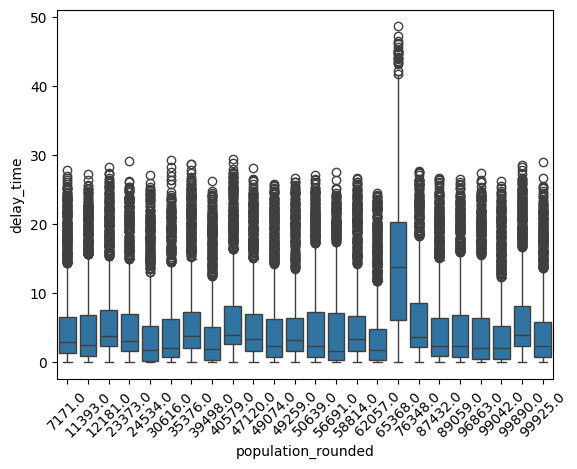

In [180]:
deliveries_enriched['population_rounded'] = deliveries_enriched['population'].round()
sns.boxplot(deliveries_enriched, x='population_rounded', y='delay_time')
plt.xticks(rotation=45)

plt.show()

In [181]:
# sns.boxplot(master, x='operating_hours', y='delay_time')
# plt.xticks(rotation=45)

# plt.show()

In [182]:
# sns.boxplot(master, x='maintenance_schedule', y='delay_time')
# plt.xticks(rotation=45)

# plt.show()

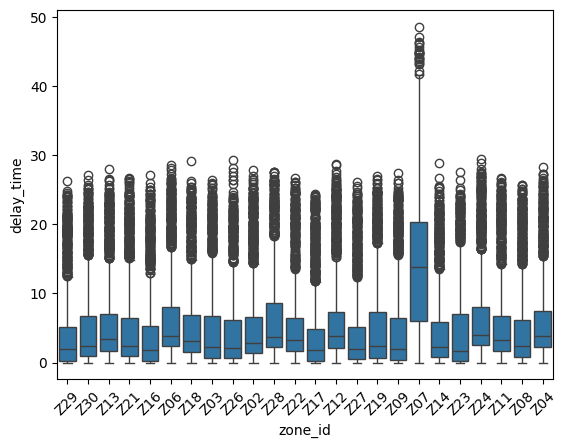

In [183]:
# deliveries_enriched['population_rounded'] = deliveries_enriched['population'].round()
sns.boxplot(deliveries_enriched, x='zone_id', y='delay_time')
plt.xticks(rotation=45)

plt.show()

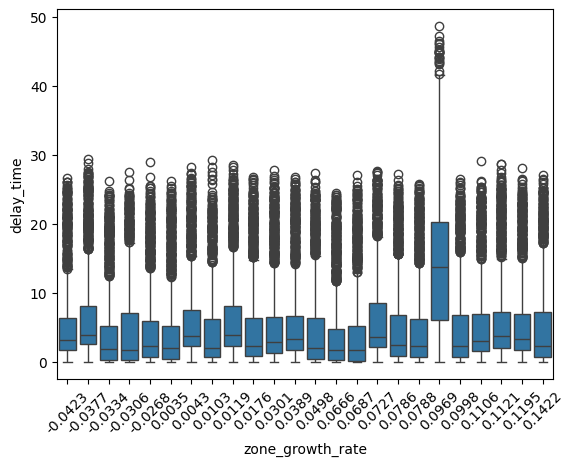

In [184]:
sns.boxplot(deliveries_enriched, x='zone_growth_rate', y='delay_time')
plt.xticks(rotation=45)

plt.show()

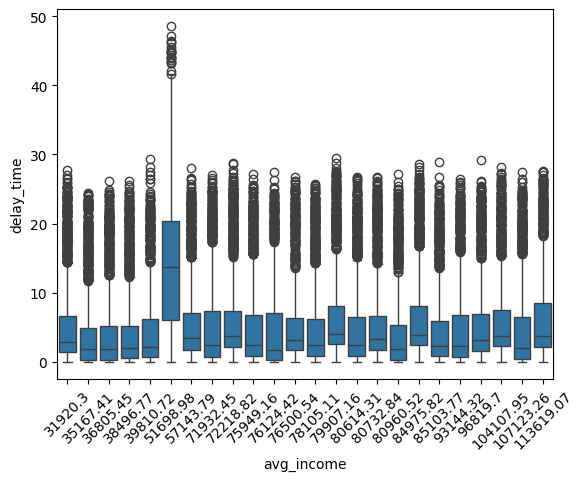

In [185]:
sns.boxplot(deliveries_enriched, x='avg_income', y='delay_time')
plt.xticks(rotation=45)

plt.show()

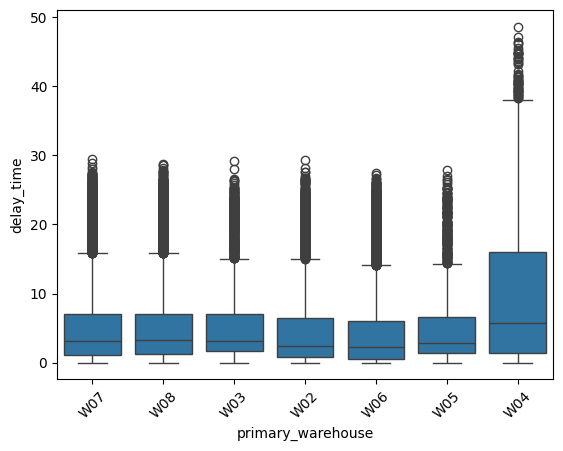

In [186]:
sns.boxplot(deliveries_enriched, x='primary_warehouse', y='delay_time')
plt.xticks(rotation=45)

plt.show()

## Additional Metrics: Zone Type & Urban Density

Beyond the previously analyzed factors, I also considered **Zone Type**  
and **Urban Density** as potential influencers of delivery performance.  

Given the patterns already observed with variables such as **Population**,  
**Zone ID**, **Average Income**, and **Primary Warehouse**, I expect a  
**similar type of variation** from Zone Type and Urban Density as well.  

If these metrics also align with the earlier findings, it would further  
strengthen the assumption that certain **geographical or demographic clusters**  
are consistently associated with higher delivery delays.  


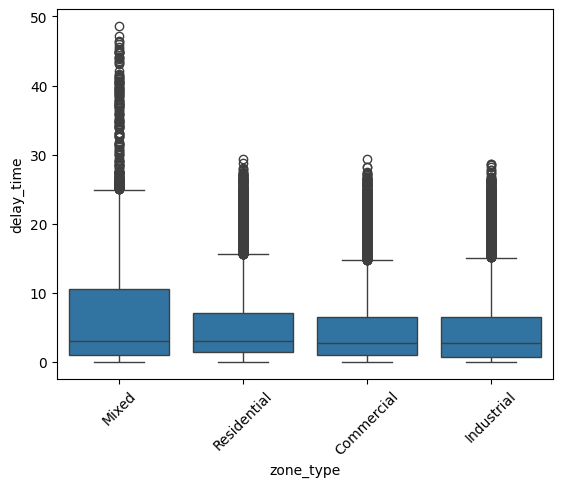

In [187]:
sns.boxplot(deliveries_enriched, x='zone_type', y='delay_time')
plt.xticks(rotation=45)

plt.show()

In [188]:
# sns.boxplot(master, x='avg_delivery_time', y='delay_time')
# plt.xticks(rotation=45)

# plt.show()

## Findings: Zone Type & Urban Density

As expected, the analysis of **Zone Type** and **Urban Density** revealed  
a **similar delay pattern** to the other geographical and demographic factors.  

- Deliveries in **zones with mixed Industrial, Commercial, and Residential**  
  characteristics experienced **higher delays** compared to more homogeneous zones.  
- This reinforces the earlier finding that certain **regional or structural factors**  
  (e.g., mixed-use congestion, traffic complexity, or service demand diversity)  
  may be driving delivery performance issues.  

Taken together with Population, Zone ID, Average Income, Primary Warehouse,  
and Distance from Hub, these results suggest that a **specific cluster of areas**  
is consistently contributing to longer delivery times.  

⚠️ However, without explicit regional mapping in the dataset, this conclusion  
remains an **informed assumption** rather than a confirmed fact.


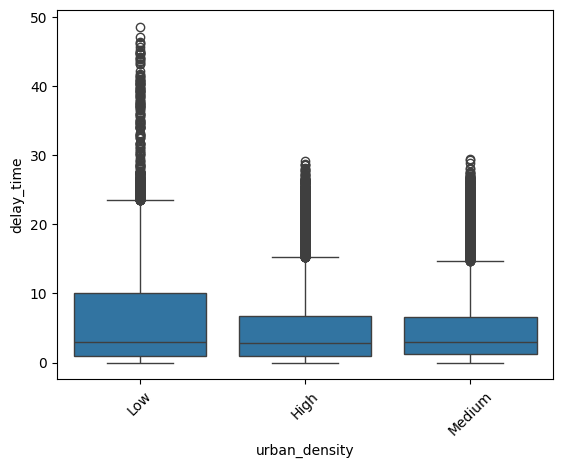

In [189]:
sns.boxplot(deliveries_enriched, x='urban_density', y='delay_time')
plt.xticks(rotation=45)

plt.show()

## Findings: Urban Density and Delivery Delays

The analysis of **Urban Density** showed a clear trend:

- Deliveries in **low-density areas** experienced **higher delays**.  
- In contrast, **medium- and high-density areas** had **lower delay times**.  

This pattern is logical because in **sparsely populated regions**, the **distance between  
consecutive delivery locations** is often larger, leading to increased travel time.  
Meanwhile, in **denser areas**, delivery points are closer together, making it easier  
to complete more deliveries in less time despite potential congestion.  

This reinforces the idea that **geographical context** (density and zone type) plays  
a critical role in shaping delivery performance.


## Parking Difficulty as a Factor in Delivery Performance

After analyzing geographical and demographic variables, I shifted focus to  
**Parking Difficulty**, which is expected to be a **crucial operational factor**  
impacting delivery performance.  


By examining parking difficulty alongside previous metrics such as **Zone Type**  
and **Urban Density**, the goal is to determine whether it reinforces the observed  
patterns of regional delivery challenges.


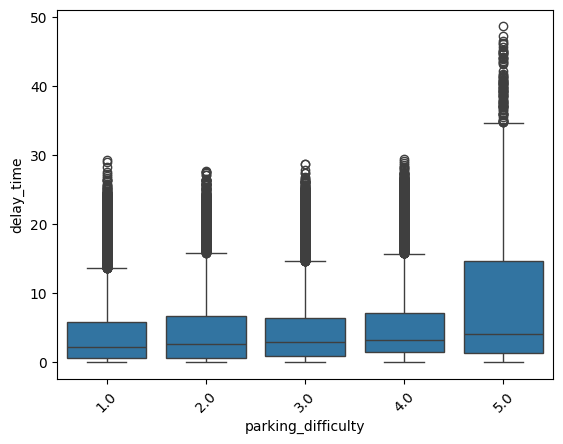

In [190]:
sns.boxplot(deliveries_enriched, x='parking_difficulty', y='delay_time')
plt.xticks(rotation=45)

plt.show()

## Findings: Parking Difficulty and Delivery Delays

As expected, **Parking Difficulty** showed a strong impact on delivery performance:  

- Deliveries in areas with **high parking difficulty** experienced **nearly double the delays**  
  compared to areas with easier parking access.  
- This confirms that parking availability is a **critical operational bottleneck**,  
  adding significant time to the delivery process.  

These results align with the broader geographic and demographic analysis, reinforcing  
that **infrastructure and accessibility challenges** — not just distance — play a  
major role in shaping delivery efficiency.  
